In [1]:
import os
import time
import sklearn
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
from sklearn import metrics, cross_validation
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import decomposition
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline

In [3]:
time.asctime()

'Mon May 22 23:25:30 2017'

In [4]:
path = os.path.expanduser('/Users/cthoyt/Downloads/esrd_timeseries_admit_comorbidities9_10_all.csv')
df = pd.read_csv(path, index_col=0, true_values=['Y', 'TRUE'], false_values=['N', 'FALSE'])

df['PCI_type'] = list(map(str.lower, df['PCI_type']))

df['Male'] = [e == 'Male' for e in df['sex']]
del df['sex']

skip = {
    'timedelta_24', 
    'Cathlab_time_24', 
    'creatinine_24', 
    'clearance_24',
    'timedelta_48', 
    'Cathlab_time_48', 
    'creatinine_48', 
    'clearance_48',
    'timedelta_72', 
    'Cathlab_time_72', 
    'creatinine_72', 
    'clearance_72', 
    'aki_24_creatinine', 
    'aki_48_creatinine', 
    'aki_72_creatinine',
    'aki_24_clearance', 
    'aki_48_clearance', 
    'aki_72_clearance', 
    'pie.id', 
    'timedelta',
    'visit.type',
    'race_y',
    'gender', 
    'age_x', 
    'length.stay_y'
}

df = df[list(set(df.columns) - skip)]

# Turn all categorical variables into dummy variables
catColumns = df.select_dtypes(['object']).columns

for c in catColumns:
    c_dummies = pd.get_dummies(df[c])
    del df[c]
    df[c_dummies.columns] = c_dummies
    
df.head()

,height,Deceased,NSTEMI,ACS,length.stay_x,CVCL,STEMI,nephrotoxic,Prehydration,Anemia,...,Tfr/Hosp,Direct,Emergency,Medical Observation,OB Unregistered,Preadmit Not OB,African American,Asian,Other,White/Caucasian
3,167.64,0,False,False,15.000000,2.590061,False,False,1086.0,True,...,0,0,1,0,0,0,0,0,1,0
5,170.18,0,False,False,8.750000,0.950940,False,True,750.0,False,...,0,0,1,0,0,0,0,0,0,1
6,165.10,0,False,False,5.375000,2.714740,False,True,240.0,False,...,0,0,1,0,0,0,0,0,0,1
7,177.80,0,False,False,2.916667,3.550685,False,False,0.0,False,...,0,0,1,0,0,0,0,0,1,0
15,177.80,0,False,False,6.500000,3.802853,False,True,72.0,False,...,0,0,1,0,0,0,0,1,0,0


In [5]:
print('Patients sans AKI:', (~df['aki']).sum())
print('Patients with AKI:', df['aki'].sum())

Patients sans AKI: 358
Patients with AKI: 37


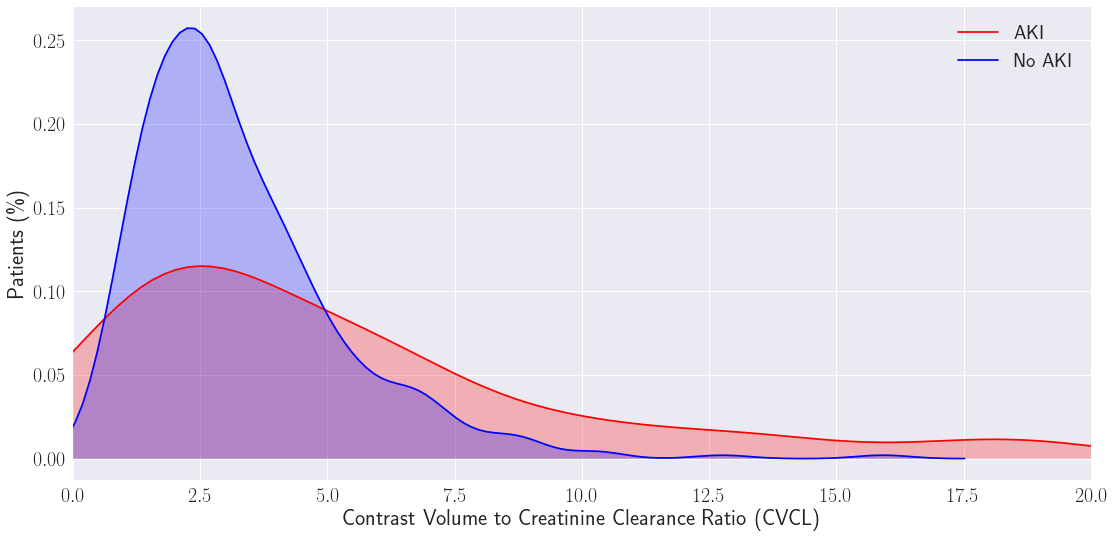

In [6]:
plt.figure(figsize=(16, 8))
sns.set(font_scale=2.0)
ax = sns.kdeplot(df.loc[df['aki'], 'CVCL'], shade=True, color="r", label='AKI')
sns.kdeplot(df.loc[~df['aki'], 'CVCL'], shade=True, color="b", ax=ax, label='No AKI')
plt.xlim(0, 20)
plt.xlabel('Contrast Volume to Creatinine Clearance Ratio (CVCL)')
plt.ylabel('Patients (\%)')
#plt.title('Kernel Density Estimate of Patients \nwith/without Acute Kidney Injury (AKI)', fontsize=40)
plt.tight_layout()
plt.show()

In [7]:
X = df[[c for c in df.columns if c != 'aki']]
y = df['aki']

In [8]:
selected_columns = [
    'Contrast_volume',
    'clearance',
    'Prehydration',
    'Posthydration',
    'Bedded Outpatient',
    'HF',
    'Anemia',
]

# First Attempt

## Step 1 - Choose a Model

We chose a logistic regression model to start because it's simple and is suited to handle binary response variable (instead of a continuous one, for which one should use a multiple linear regression)

In [9]:
logreg = linear_model.LogisticRegression(C=1e5)

## Step 2 - Train the model with Cross Validation

1. Split data into 80% training and 20% testing set, maintaining the same ratio of response values in each
2. Build model on training data
3. Apply model to testing data
4. Compare results from application on testing data to real values for that testing data

5. Do this for multiple trials of splitting your data (this is the cross-validation part, done to get more statistical power)

In [10]:
predicted = cross_validation.cross_val_predict(logreg, X, y, cv=10)

print('Accuracy:\n', metrics.accuracy_score(y, predicted))
classification_results = metrics.classification_report(y, predicted)
print('\nClasification Results:\n', classification_results)

Accuracy:
 0.848101265823

Clasification Results:
              precision    recall  f1-score   support

      False       0.94      0.89      0.91       358
       True       0.30      0.46      0.36        37

avg / total       0.88      0.85      0.86       395



# Second Attempt

Last time the results didn't give a very good explanation of what was powering the model. Now we're going to start more simple with a univariate analysis

## Building a Linear Model with L2 Regularization

This regularization reduces the effect of unimportant variables during model building and gets around the problem of having fewer data, where normal machine learning methods require a step for feature selection then another step for training and validation

In [11]:
lsvc_l1 = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)

Assess the goodness of the model.

In [12]:
predicted = cross_validation.cross_val_predict(lsvc_l1, X, y, cv=10)
print(metrics.accuracy_score(y, predicted))
classification_results = metrics.classification_report(y, predicted)
print(classification_results)

0.896202531646
             precision    recall  f1-score   support

      False       0.91      0.98      0.94       358
       True       0.33      0.11      0.16        37

avg / total       0.86      0.90      0.87       395



The L1 regularization was too strict and produced a classifier that just returns false on each. This is an artifact of the fact that the training set has a very uneven number of True and False AKI patients. Next, the L2 regularization is tried.

In [13]:
lsvc_l2 = LinearSVC(C=0.01, penalty="l2", dual=False).fit(X, y)

predicted = cross_validation.cross_val_predict(lsvc_l2, X, y, cv=10)
print(metrics.accuracy_score(y, predicted))
classification_results = metrics.classification_report(y, predicted)
print(classification_results)

0.906329113924
             precision    recall  f1-score   support

      False       0.93      0.97      0.95       358
       True       0.50      0.24      0.33        37

avg / total       0.89      0.91      0.89       395



After building the model, select features that weren't regularized out.

In [14]:
model = SelectFromModel(lsvc_l2, prefit=True)

The coefficients for each feature corresponds to its usefullness in predicting AKI.

In [15]:
pd.DataFrame(list(zip(X.columns[model.get_support()], lsvc_l2.coef_[0][model.get_support()]))).sort_values(1)

,0,1
22,Home or Self Care,-0.080282
19,lm,-0.078021
12,VFIB,-0.065853
0,Deceased,-0.051983
24,Emergency Room,-0.043988
28,Other,-0.041799
3,STEMI,-0.041511
25,Physician Referral,-0.037434
7,Bedded Outpatient,-0.036040
8,emergent,-0.030579


In [16]:
#X2 = sm.add_constant(X)
#est = sm.OLS(y, X2)
#est2 = est.fit()
#print(est2.summary())

# PCA

Sort of like feature selection, PCA is able to identify the "inner structure" of the data and eliminate correlations automatically while lowering the dimensionality of the data.

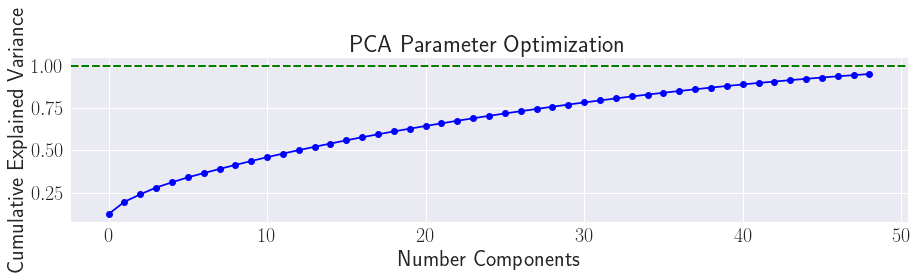

Accuracy:
 0.855696202532

Classification Results:
              precision    recall  f1-score   support

      False       0.93      0.91      0.92       358
       True       0.26      0.30      0.28        37

avg / total       0.86      0.86      0.86       395



In [17]:
pca1 = decomposition.PCA(n_components=0.95)

X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
X_pca = pca1.fit_transform(X_scaled)

plt.figure(figsize=(15, 3))

plt.title("PCA Parameter Optimization")
plt.xlabel("Number Components")
plt.ylabel("Cumulative Explained Variance")

plt.axhline(0.9990, color='r', linestyle='--', linewidth=2)
plt.axhline(0.9995, color='y', linestyle='--', linewidth=2)
plt.axhline(0.9999, color='g', linestyle='--', linewidth=2)
plt.plot(np.cumsum(pca1.explained_variance_ratio_), 'bo-')
#plt.ylim(0.998, 1)

plt.show()

logreg = linear_model.LogisticRegression(C=1e5)

predicted = cross_validation.cross_val_predict(logreg, X_pca, y, cv=10)
print('Accuracy:\n', metrics.accuracy_score(y, predicted))
classification_results = metrics.classification_report(y, predicted)
print('\nClassification Results:\n', classification_results)

The results from PCA show that as the data are normalized (by either a min-max normalization or standard normalization) that there are no principal components that explain a significant portion of the variance. This means that PCA is an unsuccessful technique.

# Recursive Feature Elimination

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-sco

Optimal number of features : 6


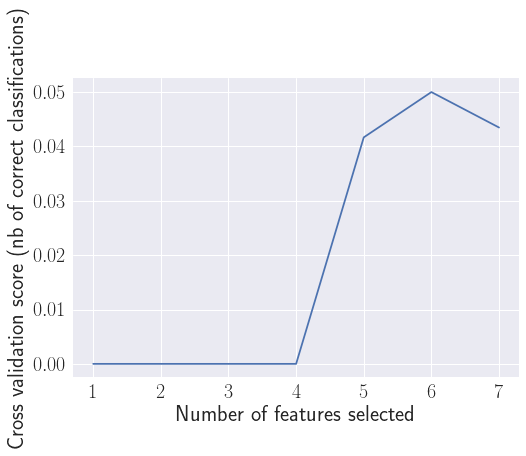

In [19]:
X_sliced = df[selected_columns]


# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2), scoring='f1')
rfecv.fit(X_sliced, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()
